In [33]:
import pandas as pd

In [34]:
weather_df = pd.read_csv('weather_2021.01.01-2022.10.31.csv')
weather_df.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2021-01-01,2.7,1.5,5.7,15.2,NaN,335.0,15.5,31.0,1008.6,NaN
1,2021-01-02,1.3,0.5,2.7,0.8,NaN,336.0,24.7,44.0,1010.1,NaN
2,2021-01-03,0.7,-0.3,1.6,0.0,NaN,327.0,17.1,38.9,1012.1,NaN
3,2021-01-04,0.0,-1.0,1.1,0.0,NaN,329.0,10.6,30.0,1011.4,NaN
4,2021-01-05,0.8,-0.9,2.1,0.0,NaN,338.0,6.2,30.0,1012.1,NaN


In [35]:
# Split the date column into day, month, and year
weather_df[['year', 'month', 'day']] = weather_df['date'].str.split('-', expand=True)

weather_df.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,year,month,day
0,2021-01-01,2.7,1.5,5.7,15.2,NaN,335.0,15.5,31.0,1008.6,NaN,2021,01,01
1,2021-01-02,1.3,0.5,2.7,0.8,NaN,336.0,24.7,44.0,1010.1,NaN,2021,01,02
2,2021-01-03,0.7,-0.3,1.6,0.0,NaN,327.0,17.1,38.9,1012.1,NaN,2021,01,03
3,2021-01-04,0.0,-1.0,1.1,0.0,NaN,329.0,10.6,30.0,1011.4,NaN,2021,01,04
4,2021-01-05,0.8,-0.9,2.1,0.0,NaN,338.0,6.2,30.0,1012.1,NaN,2021,01,05


In [36]:
weather_df.isnull().sum()

date       0
tavg       0
tmin       0
tmax       0
prcp       0
snow     654
wdir       2
wspd       2
wpgt      14
pres       2
tsun     669
year       0
month      0
day        0
dtype: int64

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from bayes_opt import BayesianOptimization

# Split the date column into day, month, and year
weather_df[['year', 'month', 'day']] = weather_df['date'].str.split('-', expand=True)

# Convert year, month, and day to integers
weather_df['year'] = weather_df['year'].astype(int)
weather_df['month'] = weather_df['month'].astype(int)
weather_df['day'] = weather_df['day'].astype(int)

# Define features and targets
features = weather_df[['day', 'month', 'year']]
targets = weather_df['tavg']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

In [60]:
features.head()

,day,month,year
0,1,1,2021
1,2,1,2021
2,3,1,2021
3,4,1,2021
4,5,1,2021


In [61]:
# Function to train and evaluate the model
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # Ensure hyperparameters are integers
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    predictions = rf_model.predict(X_test)
    
    # Calculate mean squared error for each target
    mae_tavg = mean_absolute_error(y_test,predictions)
    
    # Combine errors into a single score (negative because BayesianOptimization maximizes)
    return -mae_tavg

# Define the hyperparameter space
param_bounds = {
    'n_estimators': (2, 200),
    'max_depth': (5, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(f=rf_evaluate, pbounds=param_bounds, random_state=42)

# Perform optimization
optimizer.maximize(init_points=20, n_iter=100)

# Extract the best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

print("Best Parameters:", best_params)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -1.981    | 21.85     | 3.852     | 7.856     | 120.5     |
| 2         | -1.573    | 12.02     | 1.468     | 2.465     | 173.5     |
| 3         | -1.951    | 32.05     | 3.124     | 2.165     | 194.0     |
| 4         | -1.639    | 42.46     | 1.637     | 3.455     | 38.31     |
| 5         | -1.814    | 18.69     | 2.574     | 5.456     | 59.66     |
| 6         | -1.716    | 32.53     | 1.418     | 4.337     | 74.54     |
| 7         | -1.945    | 25.52     | 3.356     | 3.597     | 103.8     |
| 8         | -1.845    | 31.66     | 1.139     | 6.86      | 35.76     |
| 9         | -2.277    | 7.927     | 3.847     | 9.725     | 162.1     |
| 10        | -1.909    | 18.71     | 1.293     | 7.474     | 89.15     |
| 11        | -1.809    | 10.49     | 2.486     | 2.275     | 182.0     |
| 12        | -1.746    | 16.65     | 

In [62]:
# Train the final model with the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

best_rf_model.fit(X_train, y_train)

# Make predictions
final_predictions = best_rf_model.predict(X_test)

# Evaluate the final model
final_mse = mean_absolute_error(y_test, final_predictions, multioutput='raw_values')
print(f"Final Mean Absolute Error for tavg: {final_mse[0]}")

# Display the results
final_results = pd.DataFrame({
    'Actual tavg': y_test,
    'Predicted tavg': final_predictions,
})

print(final_results.head())

Final Mean Absolute Error for tavg: 1.5500438981562776
     Actual tavg  Predicted tavg
361         10.5        7.517647
158         19.7       18.829412
478         11.9       14.841176
533         28.8       26.870588
275         18.1       17.488235


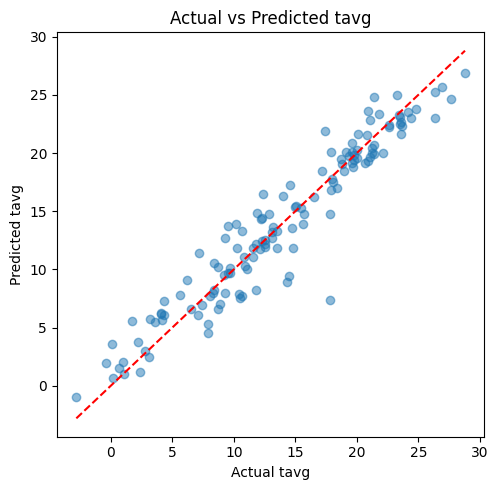

In [63]:
import matplotlib.pyplot as plt
# Plot actual vs predicted points for tavg
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.scatter(final_results['Actual tavg'], final_results['Predicted tavg'], alpha=0.5)
plt.title('Actual vs Predicted tavg')
plt.xlabel('Actual tavg')
plt.ylabel('Predicted tavg')
plt.plot([final_results['Actual tavg'].min(), final_results['Actual tavg'].max()], [final_results['Actual tavg'].min(), final_results['Actual tavg'].max()], 'r--')

plt.tight_layout()
plt.show()

In [64]:
import joblib

In [65]:
joblib_filename = 'random_forest_model.joblib'
joblib.dump(best_rf_model, joblib_filename)

['random_forest_model.joblib']

In [58]:
# Load the model from the file
loaded_rf_model = joblib.load(joblib_filename)

# Use the loaded model to make predictions
predictions = loaded_rf_model.predict(X_test)
print(predictions)

[ 7.14446499 19.76120958 14.9466762  24.28687569 16.19160985  7.24663336
  5.77871127 23.4168271  19.83697679  6.48562769 10.59737452 14.95960032
  2.2040453  22.87221169 22.35454045  6.99891366 11.04875612 21.98254107
 16.04635619 21.21513131 13.24089859 17.20422163  7.22459892  6.95686095
 17.29462866 20.53148458 20.19562704 22.3663099  17.35544187  9.65118361
 16.81249162 19.96275272 21.34115612 19.74299094 19.95749735 10.95047578
  8.5001282  16.44466521  1.00047248 16.08221443 22.26942276  6.28533827
  8.46253832 20.17295191  8.46253832 10.35463955 18.71262881 13.58651644
  8.22360364 19.61312845 22.62881324  1.80092906  9.40690215 22.96659581
  9.73025423 16.71790449 22.35454045  6.95686095  1.94200564 20.71393491
 23.52621149 12.83966959  4.28602105 24.04862716 15.07405999 16.04635619
 14.94026676 16.81249162  8.25696981 18.76001336  5.53056767  9.96931368
 16.92861498  9.11141692  5.72680085  9.32022145  6.61594258 20.75786873
 19.09285879 15.99746689 13.63502268 20.62751158 23